In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.sparse import csr_matrix
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings(action='ignore')

In [2]:

def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

        
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

def sparse_clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)


def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
    
def get_dataset_3(movies, ratings, genre_ratings):    
    # Extract action ratings from dataset
    action_movies = movies[movies['genres'].str.contains('Action') ]
    # Get average vote on action movies per user
    avg_action_votes_per_user = ratings[ratings['movieId'].isin(action_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
    # Add action ratings to romance and scifi in dataframe
    genre_ratings_3 = pd.concat([genre_ratings, avg_action_votes_per_user], axis=1)
    genre_ratings_3.columns = ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating']
    
    # Let's bias the dataset a little so our clusters can separate scifi vs romance more easily
    b1 = 3.2
    b2 = 2.5
    biased_dataset_3 = genre_ratings_3[((genre_ratings_3['avg_romance_rating'] < b1 - 0.2) & (genre_ratings_3['avg_scifi_rating'] > b2)) | ((genre_ratings_3['avg_scifi_rating'] < b1) & (genre_ratings_3['avg_romance_rating'] > b2))]
    biased_dataset_3 = pd.concat([biased_dataset_3[:300], genre_ratings_3[:2]])
    biased_dataset_3 = pd.DataFrame(biased_dataset_3.to_records())
    
    return biased_dataset_3

def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'], 
                        point['avg_romance_rating'], 
                        s=size, 
                        color=color)
    
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex(d.mean().sort_values(ascending=False).index,  axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed: Pythonic way of achieving this
            # c = c+1
            # if c > 6:
            #    break
                
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
    
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()
    
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    
    
    biased_dataset = genre_ratings[((genre_ratings['avg_Comedy_rating'] < score_limit_1 - 0.2) 
                                    & (genre_ratings['avg_Children_rating'] > score_limit_2)) |
                                   ((genre_ratings['avg_Children_rating'] < score_limit_1) 
                                    & (genre_ratings['avg_Comedy_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Open data

In [3]:
movies = pd.read_csv('dataSet/movie.csv')
movies_temp = movies
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies_temp.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# genres category

In [5]:
genres = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [6]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [7]:
movies_encoded = movies.copy()

In [8]:
for genre in genres:
    movies_encoded[genre] = movies["genres"].str.contains(genre).astype('int')
movies_encoded.drop('genres', axis=1, inplace=True)
movies_encoded

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27274,131256,"Feuer, Eis & Dosenbier (2002)",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27275,131258,The Pirates (2014),1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27276,131260,Rentun Ruusu (2001),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
X = movies_encoded[movies_encoded[movies_encoded.columns[2:]].columns].values
X

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0]])

In [10]:
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, 1500, 100)

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

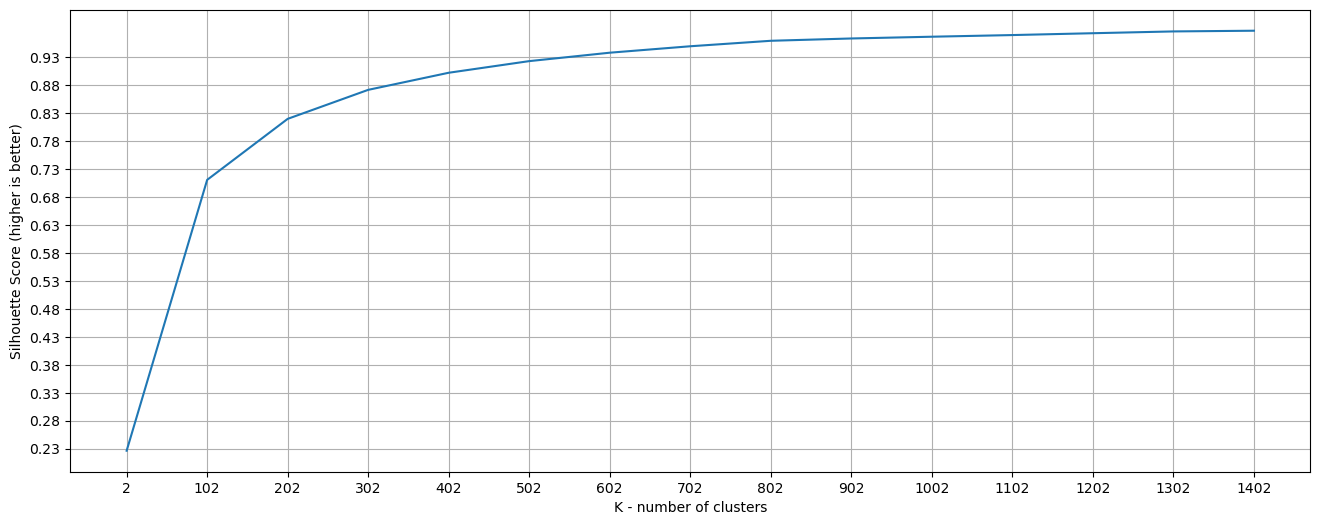

In [11]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 100)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [12]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [13]:
kmeans = KMeans(700)
clusters = kmeans.fit_predict(movies_encoded[movies_encoded.columns[2:]])

In [14]:
clusters

array([ 81,  90,   8, ...,  92,  18, 685])

In [15]:
movies_cluster = pd.DataFrame(movies['title'])
movies_cluster['cluster'] = clusters.tolist()
movies_cluster

,title,cluster
0,Toy Story (1995),81
1,Jumanji (1995),90
2,Grumpier Old Men (1995),8
3,Waiting to Exhale (1995),22
4,Father of the Bride Part II (1995),6
...,...,...
27273,Kein Bund für's Leben (2007),6
27274,"Feuer, Eis & Dosenbier (2002)",6
27275,The Pirates (2014),92
27276,Rentun Ruusu (2001),18


In [16]:
tfidf_vector = TfidfVectorizer()
tfidf_matrix = tfidf_vector.fit_transform(movies_temp['genres']).toarray()
tfidf_matrix_feature = tfidf_vector.get_feature_names()

In [17]:
%%time
cosine_sim = cosine_similarity(tfidf_matrix)

Wall time: 9.16 s


In [18]:
df_cosine = pd.DataFrame(cosine_sim, index = movies.title, columns = movies.title)
df_cosine

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Ants in the Pants (2000),Werner - Gekotzt wird später (2003),Brother Bear 2 (2006),No More School (2000),Forklift Driver Klaus: The First Day on the Job (2001),Kein Bund für's Leben (2007),"Feuer, Eis & Dosenbier (2002)",The Pirates (2014),Rentun Ruusu (2001),Innocence (2014)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.813394,0.159187,0.143854,0.264175,0.0,0.159187,0.656858,0.0,0.266892,...,0.159187,0.581714,1.000000,0.264175,0.144250,0.264175,0.264175,0.419151,0.0,0.537488
Jumanji (1995),0.813394,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.807552,0.0,0.328122,...,0.000000,0.000000,0.813394,0.000000,0.000000,0.000000,0.000000,0.515311,0.0,0.660797
Grumpier Old Men (1995),0.159187,0.000000,1.000000,0.903678,0.602583,0.0,1.000000,0.000000,0.0,0.000000,...,1.000000,0.273653,0.159187,0.602583,0.329033,0.602583,0.602583,0.000000,0.0,0.000000
Waiting to Exhale (1995),0.143854,0.000000,0.903678,1.000000,0.544541,0.0,0.903678,0.000000,0.0,0.000000,...,0.903678,0.247294,0.143854,0.544541,0.297340,0.544541,0.544541,0.000000,0.0,0.000000
Father of the Bride Part II (1995),0.264175,0.000000,0.602583,0.544541,1.000000,0.0,0.602583,0.000000,0.0,0.000000,...,0.602583,0.454133,0.264175,1.000000,0.546038,1.000000,1.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kein Bund für's Leben (2007),0.264175,0.000000,0.602583,0.544541,1.000000,0.0,0.602583,0.000000,0.0,0.000000,...,0.602583,0.454133,0.264175,1.000000,0.546038,1.000000,1.000000,0.000000,0.0,0.000000
"Feuer, Eis & Dosenbier (2002)",0.264175,0.000000,0.602583,0.544541,1.000000,0.0,0.602583,0.000000,0.0,0.000000,...,0.602583,0.454133,0.264175,1.000000,0.546038,1.000000,1.000000,0.000000,0.0,0.000000
The Pirates (2014),0.419151,0.515311,0.000000,0.000000,0.000000,0.0,0.000000,0.638115,0.0,0.636744,...,0.000000,0.000000,0.419151,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.555125


In [19]:
#function : recomend similar movies

def genre_recommendations(target_title, matrix, items, cluster, k=10):
    recom_idx = matrix.loc[:, target_title].values.reshape(1, -1).argsort()[:, ::-1].flatten()[1:k+1]
    recom_title = items.iloc[recom_idx, :].title.values
    recom_genre = items.iloc[recom_idx, :].genres.values
    target_title_list = np.full(len(range(k)), target_title)
    target_genre_list = np.full(len(range(k)), items[items.title == target_title].genres.values)
    target_cluster_list = np.full(len(range(k)), cluster[cluster.title == target_title].cluster)
    d = {
        'title':target_title_list,
        'recommendation' : recom_title,
        'cluster' : target_cluster_list,
    }
    
    return pd.DataFrame(d)

In [20]:
genre_recommendations('Toy Story (1995)', df_cosine, movies, movies_cluster)

,title,recommendation,cluster
0,Toy Story (1995),Aladdin (1992),81
1,Toy Story (1995),Toy Story Toons: Hawaiian Vacation (2011),81
2,Toy Story (1995),"Adventures of Rocky and Bullwinkle, The (2000)",81
3,Toy Story (1995),"Wild, The (2006)",81
4,Toy Story (1995),The Magic Crystal (2011),81
5,Toy Story (1995),Turbo (2013),81
6,Toy Story (1995),DuckTales: The Movie - Treasure of the Lost La...,81
7,Toy Story (1995),"Emperor's New Groove, The (2000)",81
8,Toy Story (1995),Asterix and the Vikings (Astérix et les Viking...,81
9,Toy Story (1995),Toy Story 2 (1999),81
